In [1]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

logging.basicConfig(format='%(message)s', level=logging.INFO)

import absl.logging
absl.logging.set_verbosity(absl.logging.FATAL)

import concurrent.futures

In [2]:
print("Starting experiments...")

Starting experiments...


In [3]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 15000
mtd_interval = [200]
network_size = [300]
total_nodes = 300
new_network = True

trial = 50

mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]

result_head_path = ''

In [4]:
class Experiment:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, model, trial, result_head_path, file_name=None, attacker_sensitivity=1):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.model = model
        self.trial = trial
        self.model_path = f"AI_model/models_joo_kai/main_network_{model}.h5"
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]
        self.mtd_interval = mtd_interval
        self.network_size = network_size
        self.result_head_path = result_head_path
        self.attacker_sensitivity = attacker_sensitivity

        if file_name is not None:
            self.file_name = file_name
        else:
            self.file_name = self.model


    def run_trials(self, scheme):
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = []

            for i in range(self.trial):
                if i % 10 == 0:
                    print("Trial_", i)

                if scheme == 'nomtd':
                    mtd = single_mtd_simulation("nomtd", [None], 
                                                                mtd_interval=self.mtd_interval,network_size=self.network_size) 
                elif scheme == 'mtd_ai':
                    # try:
                    #     mtd = mtd_ai_simulation(self.model, self.model_path, start_time, finish_time, total_nodes, new_network = new_network, 
                    #                                              mtd_interval=self.mtd_interval,network_size=self.network_size )  
                    # except:
                    #     continue
                    mtd = mtd_ai_simulation(self.file_name, self.model_path, start_time, finish_time, total_nodes, new_network = new_network, 
                                                mtd_interval=self.mtd_interval,network_size=self.network_size, attacker_sensitivity=self.attacker_sensitivity)    
                else:
                    mtd = specific_multiple_mtd_simulation(scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size)

    
    def get_result(self, path, scheme):
        csv_path = f'experimental_data/results/{path}.csv'
        df = pd.read_csv(csv_path)
        return df
    
    def get_result_checkpoint_median(self, scheme, data, checkpoints = 9):
        df = self.get_result(data, scheme).drop('Name', axis = 1)
        df['group'] = df.index // checkpoints
        # Group by the new column and calculate median
        df = df.groupby('group').median().reset_index(drop=True)
        # Drop the 'group' column if you don't need it in the result
        df = df.drop(columns='group', errors='ignore')
        return df

    def get_result_stats(self, checkpoint_medians,stats_type = 'median'):
        if stats_type == 'median':
            return checkpoint_medians.median()
        return checkpoint_medians.std()
    
    def raw_result_stats_pipeline(self, scheme, data, run_trial = False, stats_type = 'median', checkpoints = 9):
        if run_trial:
            self.run_trials(scheme)
        checkpoint_medians = self.get_result_checkpoint_median(scheme, data, checkpoints)
        result = self.get_result_stats(checkpoint_medians, stats_type = stats_type)
        return result
        
    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {"time_to_compromise"}  
        metrics_to_minimize = {'host_compromise_ratio', 'attack_path_exposure', 'ASR', 'ROA', 'exposed_endpoints', "risk"}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = norm_value / value
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed
        return scaled_metrics

    def scaled_pipeline(self, scheme, data, run_trial = False, stats_type = 'median'):
        nomtd_result = self.raw_result_stats_pipeline('nomtd', 'nomtd', run_trial, stats_type)
        scheme_result = self.raw_result_stats_pipeline(scheme, data, run_trial, stats_type)
        scaled_scheme_result = self.scale_metrics(scheme_result.to_dict(), nomtd_result.to_dict())
        return {scheme:scaled_scheme_result}
    
    def multiple_scaled_pipeline(self, schemes, data_name, run_trial = False, stats_type = 'median'):
        multi_schemes = {}
        nomtd_result = self.raw_result_stats_pipeline('nomtd', 'nomtd', run_trial, stats_type)
        for scheme, data in zip(schemes, data_name):
            scheme_result = self.raw_result_stats_pipeline(scheme, data, run_trial, stats_type)
            scaled_scheme_result = self.scale_metrics(scheme_result.to_dict(), nomtd_result.to_dict())

            multi_schemes[scheme] = scaled_scheme_result
        return multi_schemes


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

class RadarPlot(Experiment):
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size, total_nodes, new_network, model, trial, result_head_path):
        super().__init__(epsilon, start_time, finish_time, mtd_interval, network_size, total_nodes, new_network, model, trial, result_head_path)

    def plot_n_schemes(self, schemes_data):
        """
        Plots multiple schemes on a radar chart with a maximum cap of 5 on the values and specific metrics removed, using pastel colors.
        
        :param schemes_data: A dictionary where keys are scheme names and values are dictionaries of metrics.
        """
        # Metrics to exclude from the plot
        metrics_to_exclude = {'network_size', 'exposed_endpoints', 'mtd_interval', 'MEF', 'shortest_path_variability', 'host_compromise_ratio'}
        
        scheme_names = list(schemes_data.keys())
        first_scheme = schemes_data[scheme_names[0]]

        # Filter out excluded metrics
        labels = [label for label in first_scheme.keys() if label not in metrics_to_exclude]
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Use pastel colormap for colors
        colors = plt.cm.Pastel1.colors
        legend_patches = []

        for i, scheme_name in enumerate(scheme_names):
            metrics_values = schemes_data[scheme_name]
            
            # Filter out values corresponding to excluded metrics
            filtered_values = {k: v for k, v in metrics_values.items() if k not in metrics_to_exclude}
            
            # Cap the values at 5
            values = np.array(list(filtered_values.values()))
            values = np.minimum(values, 100)  # Cap the values at 5
            values = values.tolist()
            values += values[:1]  # Close the circle

            # Plot data with pastel colors
            ax.fill(angles, values, color=colors[i % len(colors)], alpha=0.5)
            ax.plot(angles, values, color=colors[i % len(colors)], linewidth=2, label=scheme_name)

            # Add score labels
            for j in range(num_vars):
                angle = angles[j]
                value = values[j]
                ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Add labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # Create legend
        legend_patches = [Patch(color=colors[i % len(colors)], label=scheme_name) for i, scheme_name in enumerate(scheme_names)]
        plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.1, 1.1))

        plt.show()


In [6]:
# models = ['parameter_set_1', 'parameter_set_2', 'parameter_set_3', 'parameter_set_4', 'parameter_set_5', 'parameter_set_6', 'parameter_set_7', 'parameter_set_8', 'parameter_set_9', 'parameter_set_10']
# # models = ['parameter_set_1']
# ids_sensitivity = [0, 0.25, 0.75, 1]

# for model in models:
#     for sensitivity in ids_sensitivity:
#         file_name = f"{model}_{sensitivity}"
#         print(f"Running experiments for model {model}")
#         result = Experiment(epsilon=epsilon, 
#                             start_time=start_time, 
#                             finish_time=finish_time, 
#                             mtd_interval=mtd_interval, 
#                             network_size=network_size,
#                             total_nodes=total_nodes, 
#                             new_network=new_network, 
#                             model=model, 
#                             trial=trial, 
#                             result_head_path=result_head_path, 
#                             file_name=file_name, 
#                             attacker_sensitivity=sensitivity)
#         result.run_trials('mtd_ai')

In [7]:
models = ['simultaneous']
# models = ['parameter_set_1']
ids_sensitivity = [1]

for model in models:
    for sensitivity in ids_sensitivity:
        file_name = f"{model}_{sensitivity}"
        print(f"Running experiments for model {model}")
        result = Experiment(epsilon=epsilon, 
                            start_time=start_time, 
                            finish_time=finish_time, 
                            mtd_interval=mtd_interval, 
                            network_size=network_size,
                            total_nodes=total_nodes, 
                            new_network=new_network, 
                            model=model, 
                            trial=trial, 
                            result_head_path=result_head_path, 
                            file_name=file_name, 
                            attacker_sensitivity=sensitivity)
        result.run_trials('simultaneous')

Running experiments for model simultaneous
Trial_ 0
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
Trial_ 10
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
Trial_ 20
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
Trial_ 30
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
Trial_ 40
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous
simultaneous


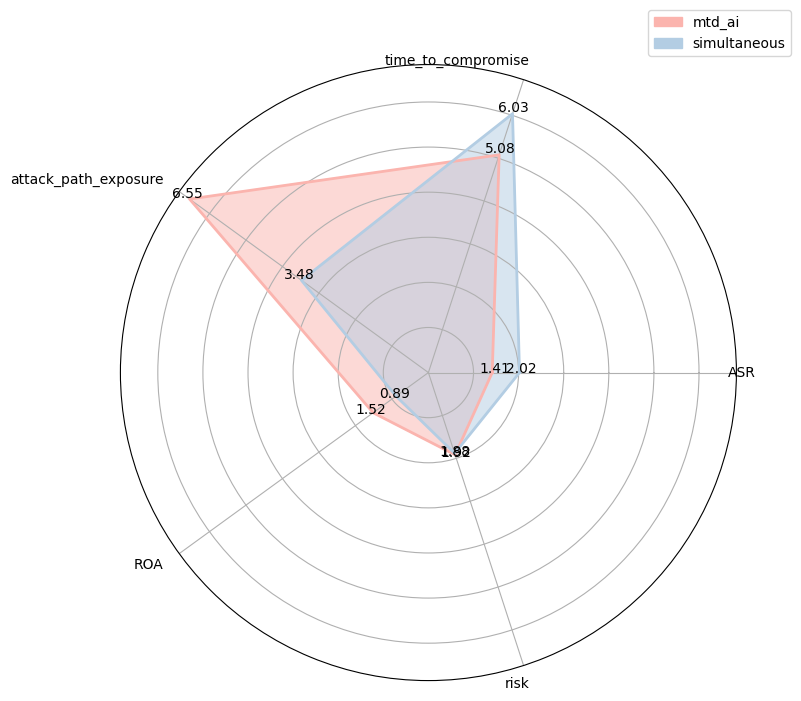

In [10]:
model = 'parameter_set_1'
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'simultaneous'], data_name=['parameter_set_1_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)


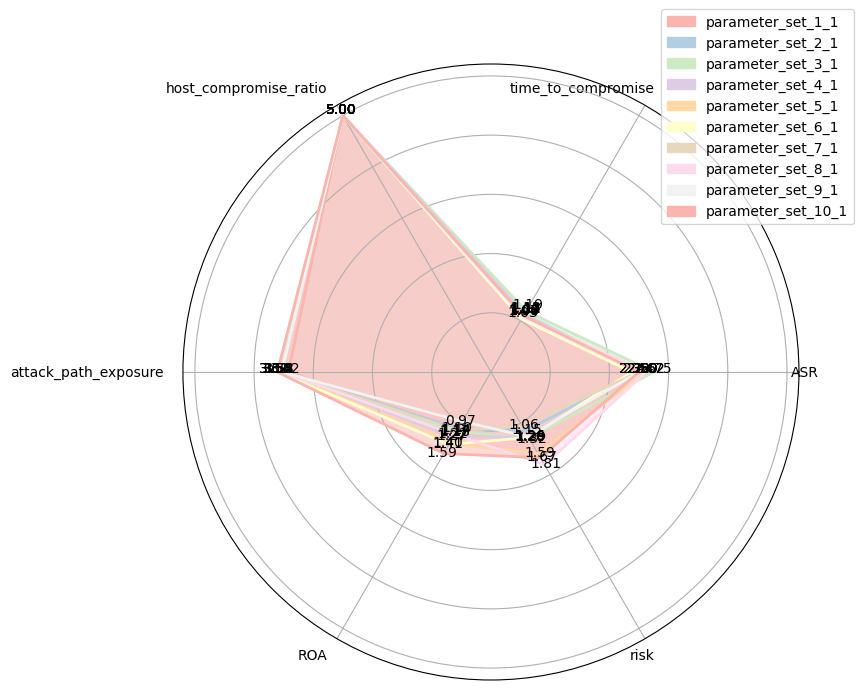

In [20]:
model = 'parameter_set_1'
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['parameter_set_1_1', 'parameter_set_2_1', 'parameter_set_3_1', 'parameter_set_4_1', 'parameter_set_5_1', 'parameter_set_6_1', 'parameter_set_7_1', 'parameter_set_8_1', 'parameter_set_9_1', 'parameter_set_10_1'], data_name=['parameter_set_1_1', 'parameter_set_2_1', 'parameter_set_3_1', 'parameter_set_4_1', 'parameter_set_5_1', 'parameter_set_6_1', 'parameter_set_7_1', 'parameter_set_8_1', 'parameter_set_9_1', 'parameter_set_10_1'], run_trial = False)
radar.plot_n_schemes(schemes_data)

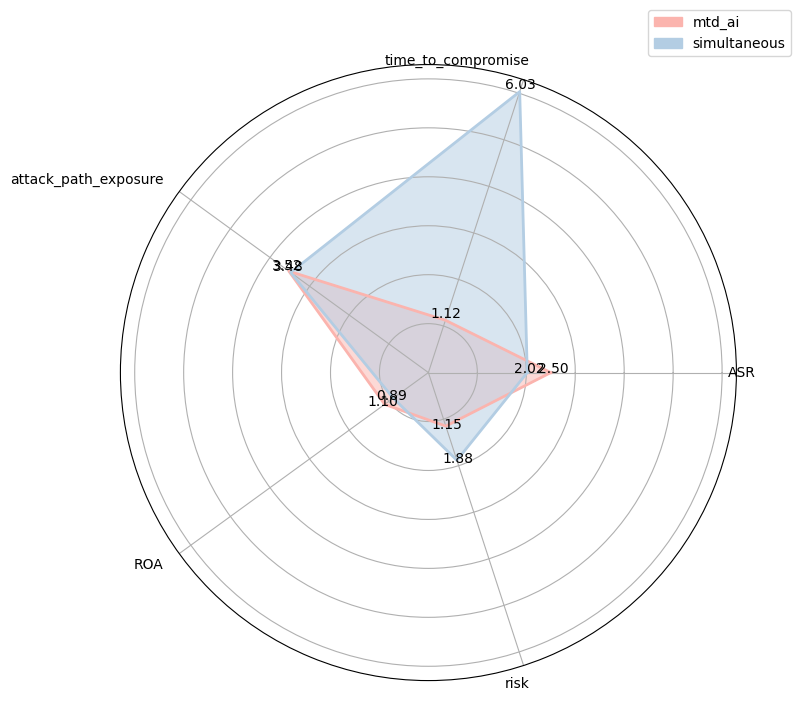

In [11]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'simultaneous'], data_name=['parameter_set_2_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

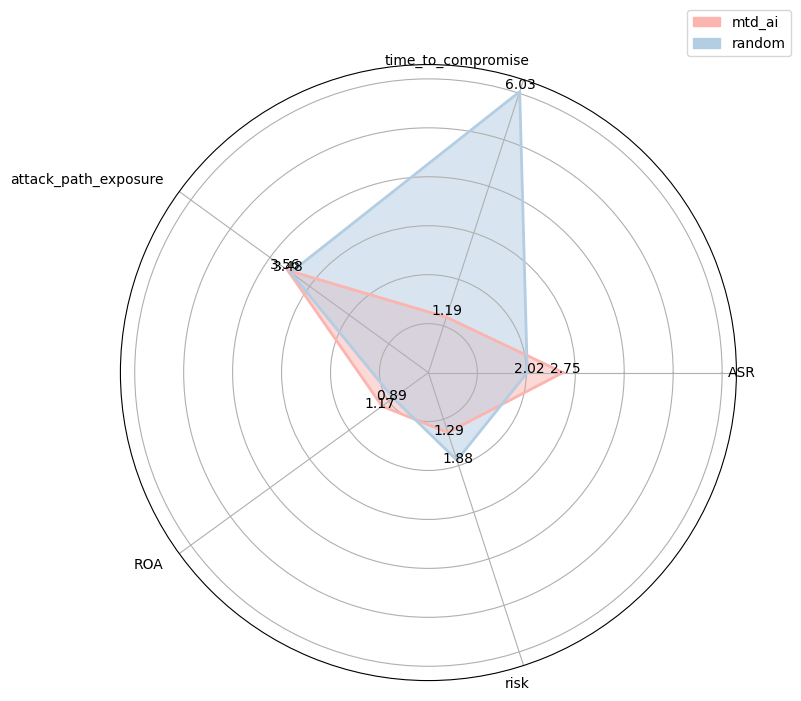

In [12]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_3_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

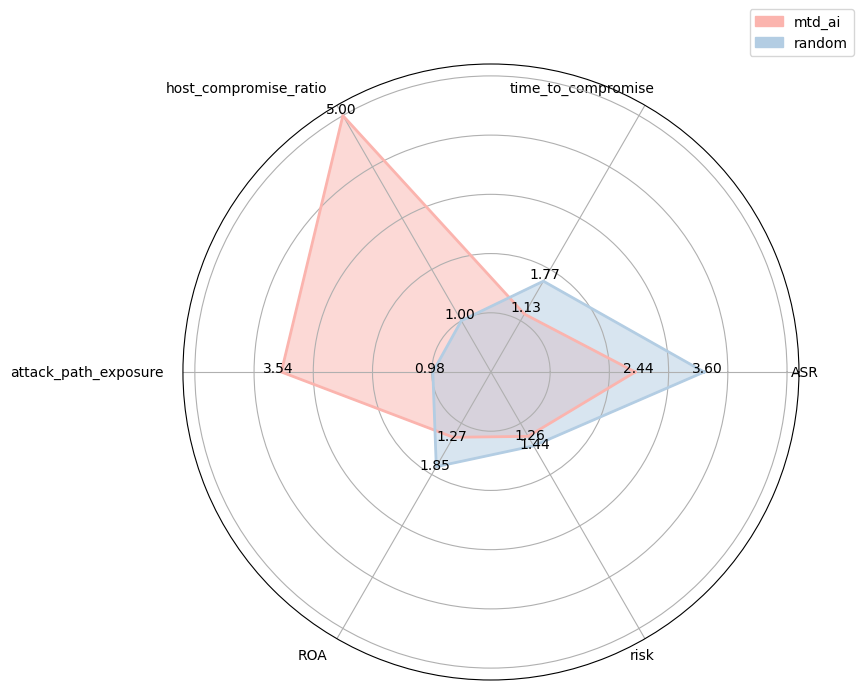

In [23]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_4_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

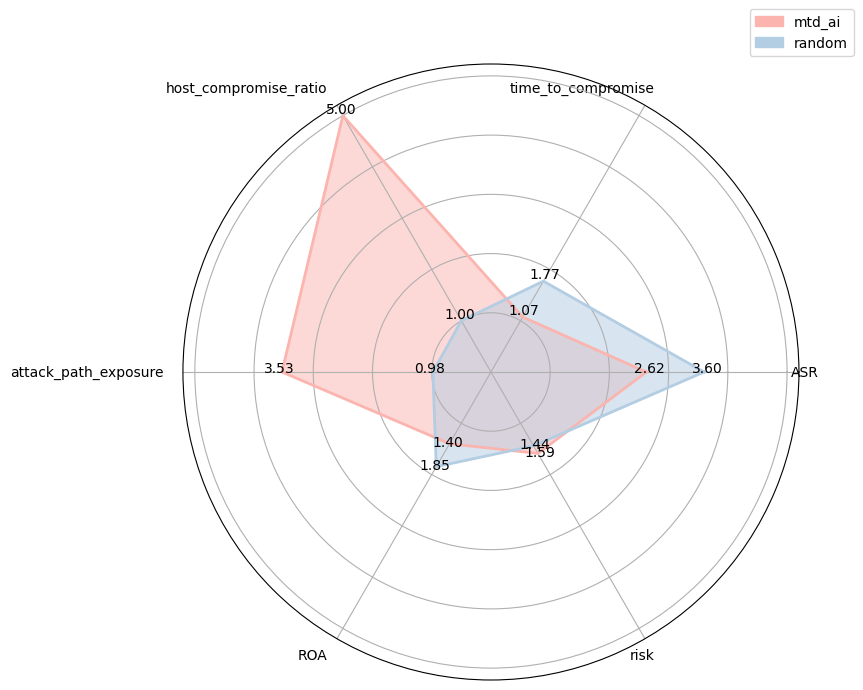

In [24]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_5_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

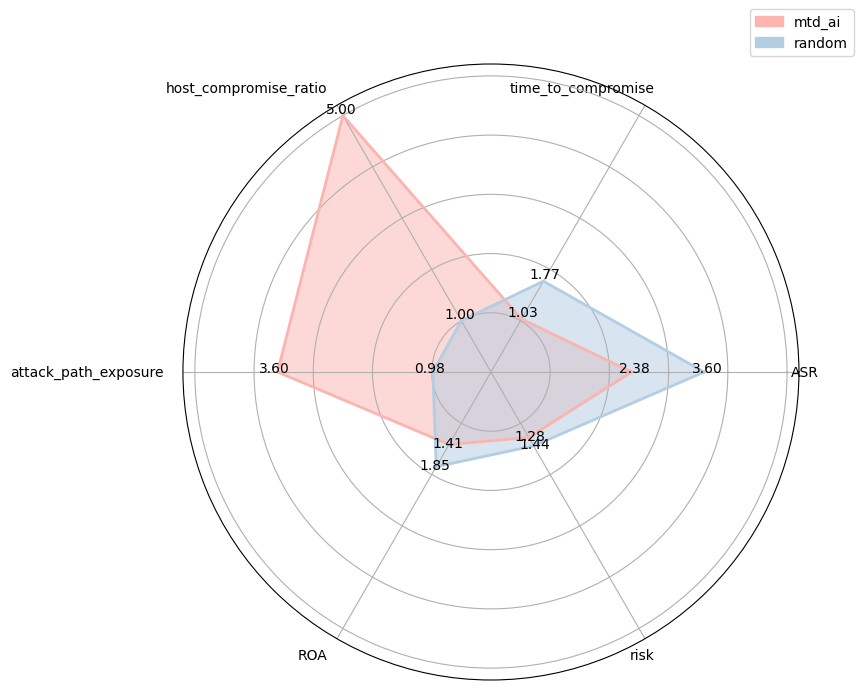

In [25]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_6_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

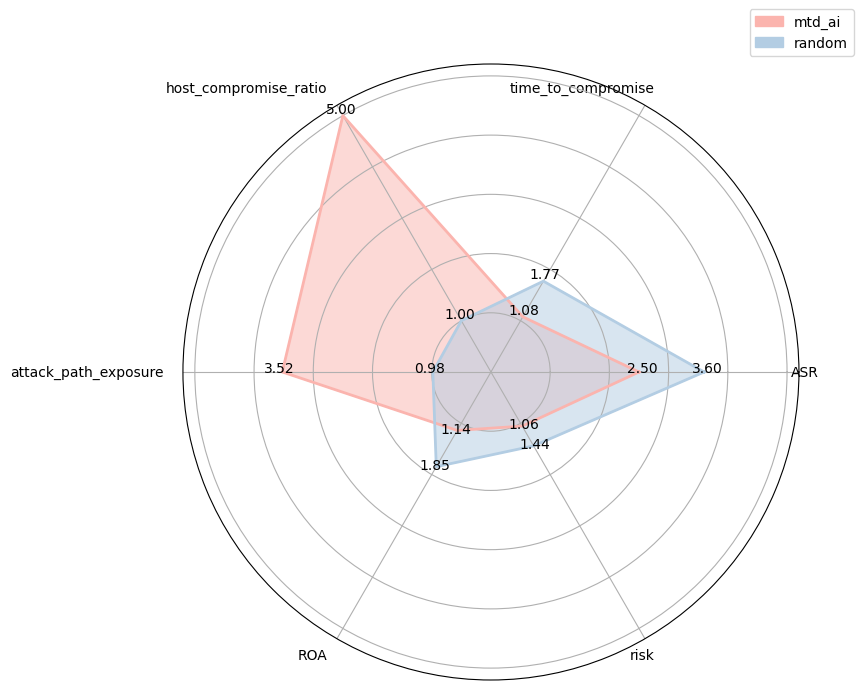

In [26]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_7_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

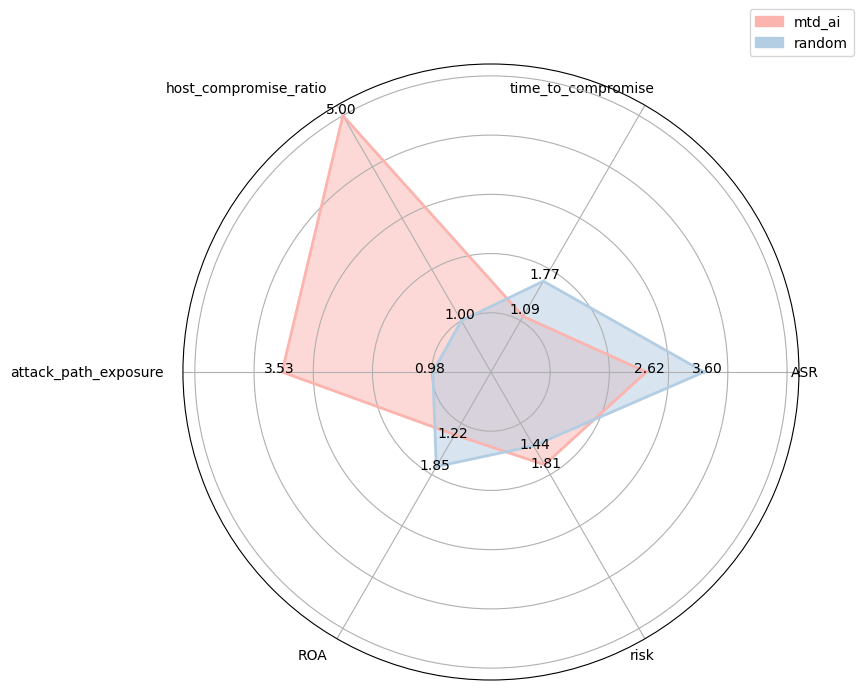

In [27]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_8_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

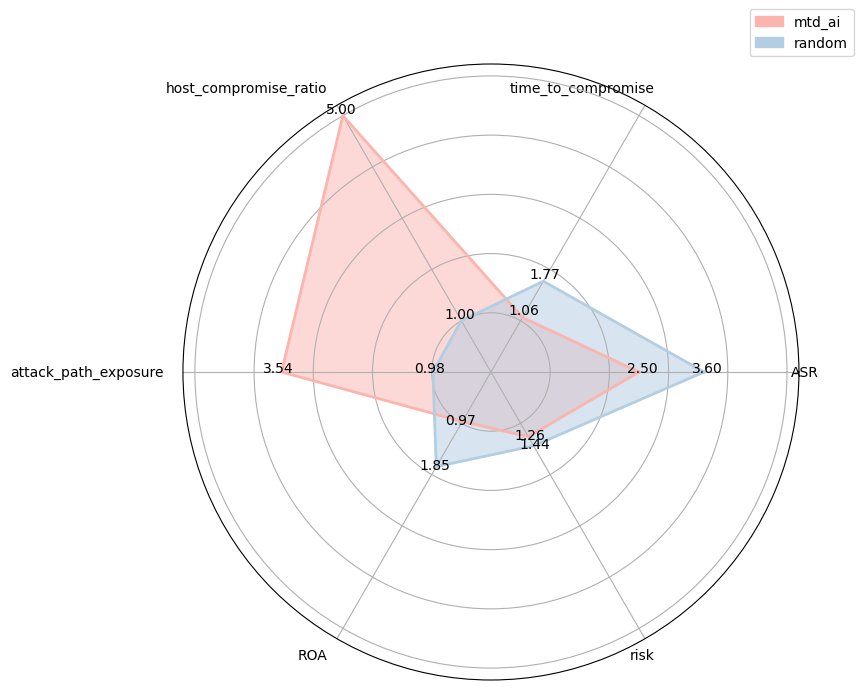

In [28]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_9_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)

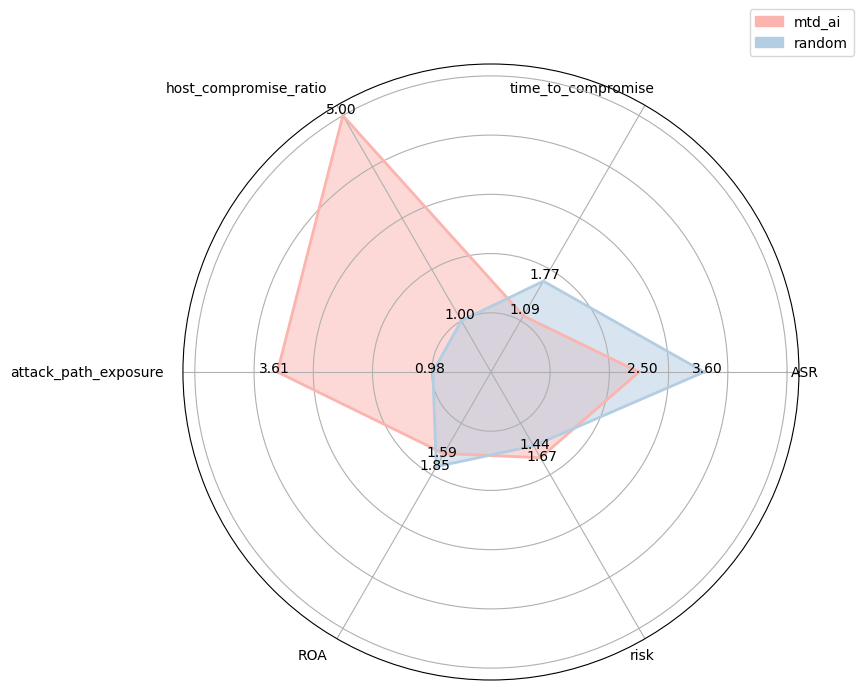

In [29]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['mtd_ai', 'random'], data_name=['parameter_set_10_1', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data)